# Setup

In [1]:
import os
import random
import cv2
import keras
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers
from PIL import Image, ImageChops, ImageEnhance
from scipy import signal

2023-10-31 01:32:11.271888: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-31 01:32:11.302293: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-31 01:32:11.302322: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-31 01:32:11.302344: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-31 01:32:11.308816: I tensorflow/core/platform/cpu_feature_g

In [2]:
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#   try:
#     for i, limit in enumerate((10000, 10000)):
#         tf.config.set_logical_device_configuration(
#                 gpus[i],[tf.config.LogicalDeviceConfiguration(memory_limit=limit)])
#   except RuntimeError as e:
#     print(e)

tf.config.list_logical_devices("GPU")

2023-10-31 01:32:13.864029: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21839 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6
2023-10-31 01:32:13.864620: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22275 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:b3:00.0, compute capability: 8.6


[LogicalDevice(name='/device:GPU:0', device_type='GPU'),
 LogicalDevice(name='/device:GPU:1', device_type='GPU')]

In [3]:
def divTup(t, a):
    assert all(i % a == 0 for i in t)
    return tuple((i // a for i in t))


def mulTup(t, a):
    return tuple((i * a for i in t))

# Filters

## ELA

In [4]:
def get_ela(img):
    tmp_path = "/tmp/triplestream.png"

    im = Image.fromarray(img).convert("RGB")
    im.save(tmp_path, "JPEG", quality=90)
    resaved_im = Image.open(tmp_path)

    ela_im = ImageChops.difference(im, resaved_im)

    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
    return np.array(ela_im)

## High Pass

In [5]:
w = np.zeros([5, 5, 1, 3])

"""first filter initializer"""
w[1, 1, 0, 0] = -1 / 4.0
w[1, 2, 0, 0] = 2 / 4.0
w[1, 3, 0, 0] = -1 / 4.0
w[2, 1, 0, 0] = 2 / 4.0
w[2, 2, 0, 0] = -4 / 4.0
w[2, 3, 0, 0] = 2 / 4.0
w[3, 1, 0, 0] = -1 / 4.0
w[3, 2, 0, 0] = 2 / 4.0
w[3, 3, 0, 0] = -1 / 4.0

""" Second filter initializer """
w[0, 0, 0, 1] = -1 / 12.0
w[0, 1, 0, 1] = 2 / 12.0
w[0, 2, 0, 1] = -2 / 12.0
w[0, 3, 0, 1] = 2 / 12.0
w[0, 4, 0, 1] = -1 / 12.0

w[1, 0, 0, 1] = 2 / 12.0
w[1, 1, 0, 1] = -6 / 12.0
w[1, 2, 0, 1] = 8 / 12.0
w[1, 3, 0, 1] = -6 / 12.0
w[1, 4, 0, 1] = 2 / 12.0

w[2, 0, 0, 1] = -2 / 12.0
w[2, 1, 0, 1] = 8 / 12.0
w[2, 2, 0, 1] = -12 / 12.0
w[2, 3, 0, 1] = 8 / 12.0
w[2, 4, 0, 1] = -2 / 12.0

w[3, 0, 0, 1] = 2 / 12.0
w[3, 1, 0, 1] = -6 / 12.0
w[3, 2, 0, 1] = 8 / 12.0
w[3, 3, 0, 1] = -6 / 12.0
w[3, 4, 0, 1] = 2 / 12.0

w[4, 0, 0, 1] = -1 / 12.0
w[4, 1, 0, 1] = 2 / 12.0
w[4, 2, 0, 1] = -2 / 12.0
w[4, 3, 0, 1] = 2 / 12.0
w[4, 4, 0, 1] = -1 / 12.0

""" Third Filter initializer"""
w[2, 1, 0, 2] = 1 / 2.0
w[2, 2, 0, 2] = -2 / 2.0
w[2, 3, 0, 2] = 1 / 2.0

bias = np.zeros(3)


def get_noise(img, filter_w=w):
    # Using just the first channel
    I = np.float32(img[:, :, 0])

    size = img.shape

    w1 = filter_w[:, :, 0, 0]
    w2 = filter_w[:, :, 0, 1]
    w3 = filter_w[:, :, 0, 2]

    C1 = signal.convolve2d(I, w1, boundary="symm", mode="same")
    C2 = signal.convolve2d(I, w2, boundary="symm", mode="same")
    C3 = signal.convolve2d(I, w3, boundary="symm", mode="same")
    C = np.zeros(size)
    C[:, :, 0] = C1
    C[:, :, 1] = C2
    C[:, :, 2] = C3

    return C

# Define Model

## Swin

In [6]:
# https://github.com/keras-team/keras-io/blob/master/examples/vision/ipynb/swin_transformers.ipynb

def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        x, shape=(-1, patch_num_y, window_size, patch_num_x, window_size, channels)
    )
    x = tf.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = tf.reshape(x, shape=(-1, window_size, window_size, channels))
    return windows


def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        windows,
        shape=(-1, patch_num_y, patch_num_x, window_size, window_size, channels),
    )
    x = tf.transpose(x, perm=(0, 1, 3, 2, 4, 5))
    x = tf.reshape(x, shape=(-1, height, width, channels))
    return x


class DropPath(layers.Layer):
    def __init__(self, drop_prob=None, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x):
        input_shape = tf.shape(x)
        batch_size = input_shape[0]
        rank = x.shape.rank
        shape = (batch_size,) + (1,) * (rank - 1)
        random_tensor = (1 - self.drop_prob) + tf.random.uniform(shape, dtype=x.dtype)
        path_mask = tf.floor(random_tensor)
        output = tf.math.divide(x, 1 - self.drop_prob) * path_mask
        return output

class WindowAttention(layers.Layer):
    def __init__(
        self, dim, window_size, num_heads, qkv_bias=True, dropout_rate=0.0, **kwargs
    ):
        super().__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(dim)

    def build(self, input_shape):
        num_window_element_pos_diff = (2 * self.window_size[0] - 1) * (
            2 * self.window_size[1] - 1
        )
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_element_pos_diff, self.num_heads),
            initializer=tf.initializers.Zeros(),
            trainable=True,
        )

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index = np.zeros(
            (num_window_elements, num_window_elements), dtype=int
        )

        coords = [
            (i, j)
            for i in range(self.window_size[0])
            for j in range(self.window_size[1])
        ]

        for i, x in enumerate(coords):
            for j, y in enumerate(coords):
                # find the diff in position between coordinates, and encode it to natural numbers
                relative_position_index[i][j] = (
                    x[0] - y[0] + self.window_size[0] - 1
                ) + (x[1] - y[1] + self.window_size[1] - 1) * (
                    2 * self.window_size[0] - 1
                )

        self.relative_position_index = tf.Variable(
            initial_value=tf.convert_to_tensor(relative_position_index), trainable=False
        )

    def call(self, x, mask=None):
        (
            _,
            size,
            channels,
        ) = x.shape  # number of windows, number of patches in a window, embed dim
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, 3, self.num_heads, head_dim))
        x_qkv = tf.transpose(
            x_qkv, perm=(2, 0, 3, 1, 4)
        )  # (q/k/v), batch, head, patch, head_dim
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = tf.transpose(k, perm=(0, 1, 3, 2))  # batch, head, head_dim, patch
        attn = q @ k  # batch, head, patch, patch

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = tf.reshape(
            self.relative_position_index, shape=(-1,)
        )
        relative_position_bias = tf.gather(
            self.relative_position_bias_table, relative_position_index_flat
        )
        relative_position_bias = tf.reshape(
            relative_position_bias, shape=(num_window_elements, num_window_elements, -1)
        )  # patch, patch, head
        relative_position_bias = tf.transpose(
            relative_position_bias, perm=(2, 0, 1)
        )  # head, patch, patch
        attn = attn + tf.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.get_shape()[0]
            mask_float = tf.cast(
                tf.expand_dims(tf.expand_dims(mask, axis=1), axis=0), tf.float32
            )
            attn = (
                tf.reshape(attn, shape=(-1, nW, self.num_heads, size, size))
                + mask_float
            )
            attn = tf.reshape(attn, shape=(-1, self.num_heads, size, size))
            attn = keras.activations.softmax(attn, axis=-1)
        else:
            attn = keras.activations.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        x_qkv = attn @ v  # batch, head, patch, head_dim
        x_qkv = tf.transpose(x_qkv, perm=(0, 2, 1, 3))  # batch, patch, head, head_dim
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, channels))  # batch, patch, embed_dim
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)
        return x_qkv


class SwinBlock(layers.Layer):
    def __init__(
        self,
        dim,
        num_patch,
        num_heads,
        window_size=7,
        shift_size=0,
        num_mlp=1024,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.dim = dim  # number of input dimensions
        self.num_patch = num_patch  # number of embedded patches
        self.num_heads = num_heads  # number of attention heads
        self.window_size = window_size  # size of window
        self.shift_size = shift_size  # size of window shift
        self.num_mlp = num_mlp  # number of MLP nodes

        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate,
        )
        self.drop_path = DropPath(dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        self.mlp = keras.Sequential(
            [
                layers.Dense(num_mlp),
                layers.Activation(keras.activations.gelu),
                layers.Dropout(dropout_rate),
                layers.Dense(dim),
                layers.Dropout(dropout_rate),
            ]
        )

        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.num_patch
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = tf.convert_to_tensor(mask_array)

            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = tf.reshape(
                mask_windows, shape=[-1, self.window_size * self.window_size]
            )
            attn_mask = tf.expand_dims(mask_windows, axis=1) - tf.expand_dims(
                mask_windows, axis=2
            )
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(initial_value=attn_mask, trainable=False)

    def call(self, x):
        height, width = self.num_patch
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = tf.reshape(x, shape=(-1, height, width, channels))
        if self.shift_size > 0:
            shifted_x = tf.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2]
            )
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(
            x_windows, shape=(-1, self.window_size * self.window_size, channels)
        )
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = tf.reshape(
            attn_windows, shape=(-1, self.window_size, self.window_size, channels)
        )
        shifted_x = window_reverse(
            attn_windows, self.window_size, height, width, channels
        )
        if self.shift_size > 0:
            x = tf.roll(
                shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2]
            )
        else:
            x = shifted_x

        x = tf.reshape(x, shape=(-1, height * width, channels))
        x = self.drop_path(x)
        x = x_skip + x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x



## Patch

In [7]:
class PatchExtract(layers.Layer):
    def __init__(self, num_patch, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.patch_size = patch_size

    def call(self, x):  # (batch_size, height, width, channels)
        x = tf.reshape(
            x,
            (
                -1,
                self.num_patch[0],
                self.patch_size[0],
                self.num_patch[0],
                self.patch_size[1],
                3,
            ),
        )  # (batch_size, patch_num_x, patch_data_x, patch_num_y, patch_data_y, channel)
        x = tf.transpose(
            x, (0, 1, 3, 2, 4, 5)
        )  # (batch_size, patch_num_x, patch_num_y, patch_data_x, patch_data_y, channel)
        return tf.reshape(
            x,
            (
                -1,
                self.num_patch[0] * self.num_patch[1],
                self.patch_size[0] * self.patch_size[1] * 3,
            ),
        )  # (batch_size, patch_num, patch_data)


class PatchMerge(layers.Layer):
    def __init__(self, patch_size, num_patch, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.patch_size = patch_size

    def call(self, x):
        x = tf.reshape(x, (-1, *self.num_patch, *self.patch_size))
        x = tf.transpose(x, (0, 1, 3, 2, 4))
        return tf.reshape(
            x,
            (
                -1,
                self.num_patch[0] * self.patch_size[0],
                self.num_patch[1] * self.patch_size[1],
            ),
        )


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.patch_count = num_patch[0] * num_patch[1]
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(
            input_dim=self.patch_count, output_dim=embed_dim
        )

    def call(self, x):
        pos = tf.range(start=0, limit=self.patch_count, delta=1)
        return self.proj(x) + self.pos_embed(pos)  # (batch_size, patch_num, embed_dim)


class PatchDeembedding(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.proj = layers.Dense(patch_size[0] * patch_size[1])

    def call(self, x):
        return self.proj(x)


class PatchDownSample(layers.Layer):
    def __init__(self, old_num_patch, old_embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.old_num_patch = old_num_patch
        self.new_num_patch = divTup(old_num_patch, 2)

        self.old_embed_dim = old_embed_dim
        new_embed_dim = 2 * old_embed_dim
        self.linear_trans = layers.Dense(new_embed_dim, use_bias=False)

    def call(self, x):
        x = tf.reshape(x, shape=(-1, *self.old_num_patch, self.old_embed_dim))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = tf.concat((x0, x1, x2, x3), axis=-1)
        x = tf.reshape(
            x,
            shape=(
                -1,
                self.new_num_patch[0] * self.new_num_patch[1],
                4 * self.old_embed_dim,
            ),
        )
        return self.linear_trans(x)


class PatchUpSample(layers.Layer):
    def __init__(self, old_num_patch, old_embed_dim, **kwargs):
        super().__init__(**kwargs)
        assert old_embed_dim % 2 == 0
        self.old_num_patch = old_num_patch
        self.new_num_patch = mulTup(old_num_patch, 2)
        self.old_embed_dim = old_embed_dim
        self.new_embed_dim = old_embed_dim // 2
        self.linear_trans = layers.Dense(4 * self.new_embed_dim, use_bias=False)

    def call(self, x):
        x = self.linear_trans(x)
        x = tf.reshape(x, shape=(-1, *self.old_num_patch, 2, 2, self.new_embed_dim))
        x = tf.transpose(x, (0, 1, 3, 2, 4, 5))

        return tf.reshape(
            x, (-1, self.new_num_patch[0] * self.new_num_patch[1], self.new_embed_dim)
        )

## Higher Components

In [8]:
class SwinBlockx2(layers.Layer):
    def __init__(
        self,
        embed_dim,
        num_patch,
        num_heads,
        window_size=7,
        shift_size=0,
        num_mlp=1024,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.swin1 = SwinBlock(
            dim=embed_dim,
            num_patch=num_patch,
            num_heads=num_heads,
            window_size=window_size,
            shift_size=0,
            num_mlp=num_mlp,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate,
        )
        self.swin2 = SwinBlock(
            dim=embed_dim,
            num_patch=num_patch,
            num_heads=num_heads,
            window_size=window_size,
            shift_size=shift_size,
            num_mlp=num_mlp,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate,
        )

    def call(self, x):
        x = self.swin1(x)
        x = self.swin2(x)
        return x

class InputBlock(layers.Layer):
    def __init__(self, patch_size, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.patchExtract = PatchExtract(patch_size=patch_size, num_patch=num_patch)
        self.patchEmbedding = PatchEmbedding(num_patch=num_patch, embed_dim=embed_dim)

    def call(self, x):
        x = self.patchExtract(x)
        x = self.patchEmbedding(x)
        return x


class EncoderBlock(layers.Layer):
    def __init__(self, embed_dim, num_patch, swin_args, **kwargs):
        super().__init__(**kwargs)
        self.swin = SwinBlockx2(embed_dim=embed_dim, num_patch=num_patch, **swin_args)

        self.downSample = PatchDownSample(
            old_num_patch=num_patch, old_embed_dim=embed_dim
        )

    def call(self, x):
        x = self.swin(x)
        x = self.downSample(x)
        return x


class DecoderBlock(layers.Layer):
    def __init__(self, embed_dim, num_patch, swin_args, **kwargs):
        super().__init__(**kwargs)

        self.upSample = PatchUpSample(old_num_patch=num_patch, old_embed_dim=embed_dim)
        embed_dim /= 2
        num_patch = mulTup(num_patch, 2)

        self.swin = SwinBlockx2(embed_dim=embed_dim, num_patch=num_patch, **swin_args)

    def call(self, x):
        x = self.upSample(x)
        x = self.swin(x)
        return x


class OutputBlock(layers.Layer):
    def __init__(self, patch_size, num_patch, **kwargs):
        super().__init__(**kwargs)

        self.linearProj = PatchDeembedding(patch_size=patch_size)
        self.patchMerge = PatchMerge(num_patch=num_patch, patch_size=patch_size)

    def call(self, x):
        x = self.linearProj(x)
        x = self.patchMerge(x)
        return x


class SwinTransformer(keras.Model):
    def __init__(
        self,
        input_shape,
        num_patch,
        swin_args,
        **kwargs
    ):
        super().__init__(**kwargs)
        assert(all(a % b == 0 for a, b in zip(input_shape, num_patch)))
        patch_size = tuple(a // b for a, b in zip(input_shape, num_patch))
        
        self.inputBlock = InputBlock(
            embed_dim=embed_dim, num_patch=num_patch, patch_size=patch_size
        )
        self.encoder1 = EncoderBlock(
            embed_dim=embed_dim, num_patch=num_patch, swin_args=swin_args
        )
        self.encoder2 = EncoderBlock(
            embed_dim=2 * embed_dim, num_patch=divTup(num_patch, 2), swin_args=swin_args
        )
        self.encoder3 = EncoderBlock(
            embed_dim=4 * embed_dim, num_patch=divTup(num_patch, 4), swin_args=swin_args
        )
        self.bottleneck = SwinBlockx2(
            embed_dim=8 * embed_dim, num_patch=divTup(num_patch, 8), **swin_args
        )
        self.decoder3 = DecoderBlock(
            embed_dim=8 * embed_dim, num_patch=divTup(num_patch, 8), swin_args=swin_args
        )
        self.decoder2 = DecoderBlock(
            embed_dim=4 * embed_dim, num_patch=divTup(num_patch, 4), swin_args=swin_args
        )
        self.decoder1 = DecoderBlock(
            embed_dim=2 * embed_dim, num_patch=divTup(num_patch, 2), swin_args=swin_args
        )
        self.outputBlock = OutputBlock(patch_size=patch_size, num_patch=num_patch)

    def call(self, x):
        x = self.inputBlock(x)
        x = self.encoder1(x)
        x = self.encoder2(x)
        x = self.encoder3(x)
        x = self.bottleneck(x)
        x = self.decoder3(x)
        x = self.decoder2(x)
        x = self.decoder1(x)
        x = self.outputBlock(x)

        return x


## Final Model

In [9]:
class TripleStreamSwinTransformer(keras.Model):
    def __init__(
        self,
        input_shape,
        num_patch,
        swin_args,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.streams = tuple(SwinTransformer(input_shape = input_shape, num_patch = num_patch, swin_args = swin_args) for i in range(3))
        self.concatenate = layers.Concatenate(axis = -1)
        self.combineResult = layers.Conv2D(1, 1, use_bias=False) # Single 1x1 filter

    
    def call(self, x):
        _, _, h, w, c = x.shape

        results = tuple(self.streams[i](tf.reshape(x[:, i, :, :, :], (-1, h, w, c))) for i in range(3))
        results = tuple(map(lambda a : tf.reshape(a, (-1, h, w, 1)), results)) # Add 1 dimension to end for concat
        x = self.concatenate(results)
        return self.combineResult(x)
        

# Train

## Load Dataset

In [10]:
img_rgbs, img_masks = [], []

## Synthetic (Bappy) Dataset
dataset_dir = "/home/cvblhcs22/iit2020/forgery/dataset/synthetic"

for fldr in ["dresden_spliced", "spliced_copymove_NIST", "spliced_NIST"]:
    mask_fldr = os.path.join(dataset_dir, fldr, "masks")
    rgb_fldr = os.path.join(dataset_dir, fldr, "rgb_imgs")

    rgbs = sorted(os.path.join(rgb_fldr, f) for f in os.listdir(rgb_fldr))
    masks = sorted(os.path.join(mask_fldr, f) for f in os.listdir(mask_fldr))

    img_rgbs.extend(rgbs)
    img_masks.extend(masks)

dataset = list(zip(img_rgbs, img_masks))
random.shuffle(dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


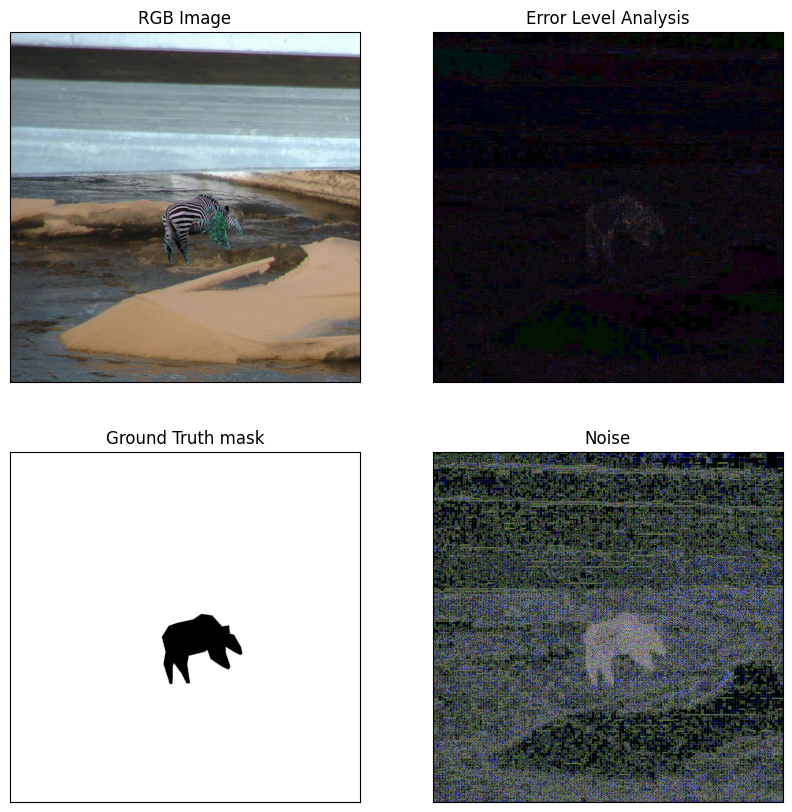

In [11]:
img, mask = (cv2.imread(l[9]) for l in (img_rgbs, img_masks))

plt.figure(figsize=(10, 10))
for i, (title, img) in enumerate(
    (
        ("RGB Image", img),
        ("Error Level Analysis", get_ela(img)),
        ("Ground Truth mask", mask),
        ("Noise", get_noise(img)),
    )
):
    plt.subplot(2, 2, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(title)
    plt.imshow(img)
# plt.savefig("foo.png", bbox_inches='tight', dpi = 1000)
plt.show()

## Build the model

In [12]:
image_dimension = 256
patch_dimension = 4
embed_dim = 128  # Embedding dimension

swin_args = {
    "dropout_rate": 0.03,  # Dropout rate
    "num_heads": 8,  # Attention heads
    "num_mlp": 256,  # MLP layer size
    "qkv_bias": True,  # Convert embedded patches to query, key, and values with a learnable additive value
    "window_size": 2,  # Size of attention window
    "shift_size": 1,  # Size of shifting window
}
input_size = (image_dimension, image_dimension)
input_shape = (image_dimension, image_dimension, 3)
patch_size = (patch_dimension, patch_dimension)
num_patch = image_dimension // patch_dimension
num_patch = (num_patch, num_patch)

assert image_dimension % patch_dimension == 0
assert embed_dim % swin_args["num_heads"] == 0

learning_rate = 1e-3
batch_size = 1000
num_epochs = 1
validation_split = 0.1
weight_decay = 0.0001

In [13]:
model = TripleStreamSwinTransformer(input_shape = input_shape, swin_args = swin_args, num_patch = num_patch)
model.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, weight_decay=weight_decay),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)
model.build((None, 3, image_dimension, image_dimension, 3))
# model.build(input_shape)


model.summary(expand_nested=True)

Model: "triple_stream_swin_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 swin_transformer (SwinTran  multiple                  22913632  
 sformer)                                                        
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_block (InputBlock)   multiple                  530560   |
|                                                               |
| encoder_block (EncoderBlo  multiple                  412592   |
| ck)                                                           |
|                                                               |
| encoder_block_1 (EncoderB  multiple                  1320112  |
| lock)                                                         |
|                                                               |
| encoder_block_2 (EncoderB  multiple                  4729520  |
| lock)                             

## Dataset Generator

In [14]:
def makeGenerators(dataset, validation_split, batch_size, target_size):
    def generator(dataset):
        total_size = len(dataset)
        while (True):
            random.shuffle(dataset)
            for batch_start in range(0, len(dataset), batch_size):
                batch_files = dataset[batch_start : batch_start + batch_size]
                if (len(batch_files) != batch_size):
                    batch_files.extend(dataset[:(len(batch_files) - batch_size)])
                
                inputs = {a : np.zeros((batch_size, *target_size, 3)) for a in ('rgb', 'ela', 'noise')}
                outputs = np.zeros((batch_size, *target_size))
                
                for i, (imgFile, maskFile) in enumerate(batch_files): 
                    img = cv2.imread(imgFile)
                    inputs['rgb'][i] = cv2.resize(img, target_size)
                    inputs['ela'][i] = cv2.resize(get_ela(img), target_size)
                    inputs['noise'][i] = cv2.resize(get_noise(img), target_size)

                yield inputs, outputs
                
    validation_split_index = int(len(dataset) * validation_split)
    val_dataset, train_dataset = dataset[:validation_split_index], dataset[validation_split_index:]
   
    return math.ceil(len(train_dataset) / batch_size), math.ceil(len(val_dataset) / batch_size), \
        generator(train_dataset), generator(val_dataset)

## Training

In [ ]:
num_train_steps, num_val_steps, train_generator, val_generator = makeGenerators(dataset, validation_split, batch_size, input_size)

history = model.fit(
    train_generator,
    validation_data = val_generator,
    epochs=num_epochs,
    steps_per_epoch=num_train_steps,
    validation_steps=num_val_steps
)